# Scatter matrix

/home/peter/src/covid19plots/env/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  if __name__ == '__main__':


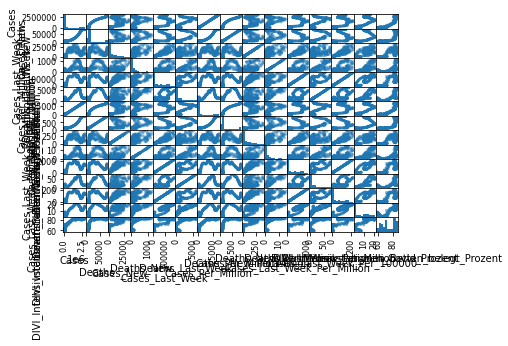

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scrape import entorb

fig, ax = plt.subplots()
area = 'DE-total'
de = entorb.to_dataframe(area)
de.drop(columns=[c for c in de.columns if "Doubling_Time" in c], inplace=True)
pd.plotting.scatter_matrix(de, figsize=(20,20), ax=ax)
fig.set_facecolor('w')
plt.show()

In [2]:
# Correlation

In [3]:
corr = de.corr()
corr.style.background_gradient(cmap='Blues')

,Cases,Deaths,Cases_New,Deaths_New,Cases_Last_Week,Deaths_Last_Week,Cases_Per_Million,Deaths_Per_Million,Cases_New_Per_Million,Deaths_New_Per_Million,Cases_Last_Week_Per_Million,Deaths_Last_Week_Per_Million,Cases_Last_Week_Per_100000,DIVI_Intensivstationen_Covid_Prozent,DIVI_Intensivstationen_Betten_belegt_Prozent
Cases,1.000000,0.975449,0.608236,0.600417,0.665537,0.694669,1.000000,0.975452,0.608236,0.600415,0.665502,0.694680,0.665502,0.793233,0.885264
Deaths,0.975449,1.000000,0.454938,0.485578,0.495472,0.576961,0.975450,0.999999,0.454903,0.485573,0.495431,0.576971,0.495431,0.636539,0.785539
Cases_New,0.608236,0.454938,1.000000,0.677549,0.918604,0.617783,0.608235,0.454915,0.999996,0.677553,0.918616,0.617799,0.918616,0.804896,0.749552
Deaths_New,0.600417,0.485578,0.677549,1.000000,0.662199,0.880364,0.600417,0.485607,0.677704,1.000000,0.662180,0.880366,0.662180,0.797143,0.679127
Cases_Last_Week,0.665537,0.495472,0.918604,0.662199,1.000000,0.713844,0.665536,0.495425,0.918716,0.662207,1.000000,0.713858,1.000000,0.904247,0.800961
Deaths_Last_Week,0.694669,0.576961,0.617783,0.880364,0.713844,1.000000,0.694669,0.576974,0.618030,0.880366,0.713818,1.000000,0.713818,0.889070,0.729937
Cases_Per_Million,1.000000,0.975450,0.608235,0.600417,0.665536,0.694669,1.000000,0.975452,0.608235,0.600415,0.665501,0.694680,0.665501,0.793233,0.885264
Deaths_Per_Million,0.975452,0.999999,0.454915,0.485607,0.495425,0.576974,0.975452,1.000000,0.454880,0.485602,0.495383,0.576984,0.495383,0.636574,0.785531
Cases_New_Per_Million,0.608236,0.454903,0.999996,0.677704,0.918716,0.618030,0.608235,0.454880,1.000000,0.677708,0.918728,0.618046,0.918728,0.805041,0.749520
Deaths_New_Per_Million,0.600415,0.485573,0.677553,1.000000,0.662207,0.880366,0.600415,0.485602,0.677708,1.000000,0.662187,0.880369,0.662187,0.797151,0.679132


# Deaths formula:

Deaths(Cases) = 
               8                 7                 6                 5
4.752e-45 Cases - 5.035e-38 Cases + 2.087e-31 Cases - 4.226e-25 Cases
                  4               3                 2
 + 4.089e-19 Cases - 1.1e-13 Cases - 8.882e-08 Cases + 0.06565 Cases - 1059


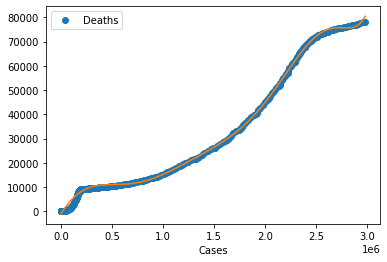

In [4]:
import numpy as np
coefs = np.polyfit(x=de['Cases'], y=de['Deaths'], deg=8)
fig, ax = plt.subplots()
de.plot(ax=ax, kind='line', x='Cases', y='Deaths', linestyle='', marker='o')
poly = np.poly1d(coefs, variable='Cases')
ax.plot(de['Cases'], poly(de['Cases']))
fig.set_facecolor('w')
print("Deaths(Cases) = ")
print(poly)

-30.504273763327916

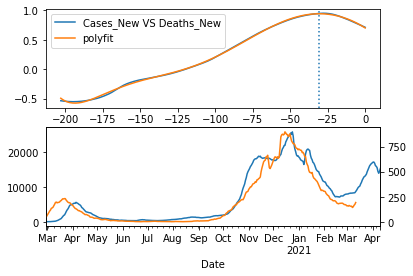

In [5]:
overlapping_days = int(0.5 * min([len(de['Cases_New']), len(de['Deaths_New'])]))

lcor = lagged_correlation = pd.DataFrame.from_dict(
    {'Cases_New VS Deaths_New': [de['Cases_New'].rolling('7D').mean().corr(de['Deaths_New'].rolling('7D').mean().shift(-t)) for t in range(overlapping_days)],
     'Delta_New': [-t for t in range(overlapping_days)]}).set_index('Delta_New')

fig, axes = plt.subplots(nrows=2)

poly = np.poly1d(np.polyfit(x=lcor.index, y=lcor['Cases_New VS Deaths_New'], deg=7), variable='r')
lag = [x.real for x in poly.deriv().r if x.imag==0 and x.real<0][-1]
display(lag)

lcor.plot(ax=axes[0])
axes[0].plot(lcor.index, poly(lcor.index), label="polyfit")
axes[0].axvline(lag, linestyle=':')
axes[0].legend()

de['Cases_New'].rolling('7D').mean().plot(ax=axes[1])
de['Deaths_New'].rolling('7D').mean().shift(int(lag)).plot(ax=axes[1], secondary_y=True)
fig.set_facecolor('w')

In [12]:
lag = dict()
for ymax in range(30, len(de['Deaths_New']), 7):
    overlapping_days = int(0.5 * min([len(de['Cases_New'][:ymax]), len(de['Deaths_New'][:ymax])]))

    lcor = lagged_correlation = pd.DataFrame.from_dict(
        {'Cases_New VS Deaths_New': [de['Cases_New'][:ymax].rolling('7D').mean().corr(de['Deaths_New'][:ymax].rolling('7D').mean().shift(-t)) for t in range(overlapping_days)],
         'Delta_New': [-t for t in range(overlapping_days)]}).set_index('Delta_New')

    poly = np.poly1d(np.polyfit(x=lcor.index, y=lcor['Cases_New VS Deaths_New'], deg=7), variable='r')
    lag[de.index[ymax]] = [x.real for x in poly.deriv().r if x.imag==0 and x.real<0][-1]
print(lag)

{Timestamp('2020-03-29 00:00:00'): -9.705417839147264, Timestamp('2020-04-05 00:00:00'): -8.633350414876599, Timestamp('2020-04-12 00:00:00'): -9.834094069613087, Timestamp('2020-04-19 00:00:00'): -10.65866775632603, Timestamp('2020-04-26 00:00:00'): -12.52160722681617, Timestamp('2020-05-03 00:00:00'): -13.471980830774907, Timestamp('2020-05-10 00:00:00'): -13.702488980875628, Timestamp('2020-05-17 00:00:00'): -13.787462991342487, Timestamp('2020-05-24 00:00:00'): -13.858835150467701, Timestamp('2020-05-31 00:00:00'): -13.934905149849216, Timestamp('2020-06-07 00:00:00'): -13.943367705289166, Timestamp('2020-06-14 00:00:00'): -13.951303004712177, Timestamp('2020-06-21 00:00:00'): -13.940232041959591, Timestamp('2020-06-28 00:00:00'): -13.853805728582465, Timestamp('2020-07-05 00:00:00'): -13.723049039253368, Timestamp('2020-07-12 00:00:00'): -13.638366611976565, Timestamp('2020-07-19 00:00:00'): -13.53298956238343, Timestamp('2020-07-26 00:00:00'): -13.465219765997494, Timestamp('2020

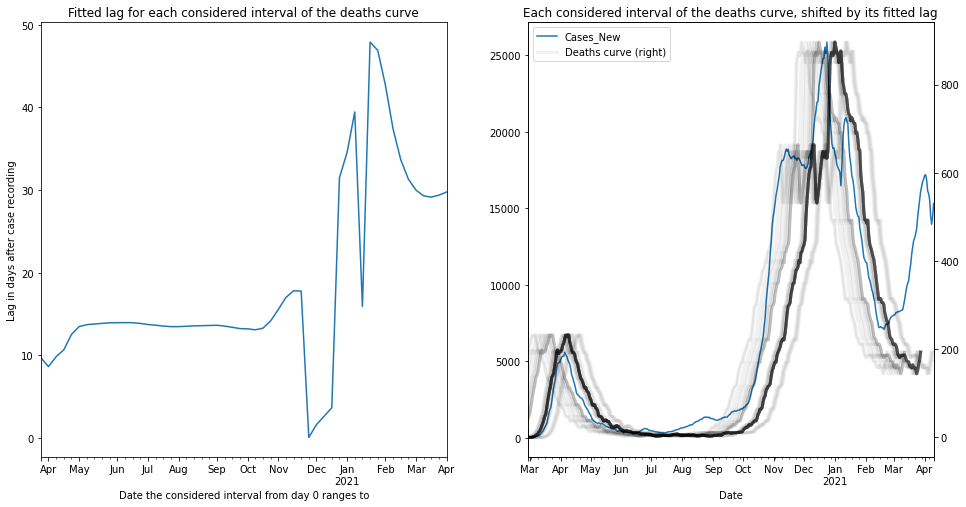

In [11]:
fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(16,8)
fig.set_facecolor('w')
keys=sorted(list(lag.keys()))
df = pd.DataFrame.from_dict({"Interval in days":keys, "Fitted lag":[lag[x] for x in keys]}).set_index("Interval in days")
df.multiply(-1).plot(kind='line', ax=axes.flat[0], legend=False, title="Fitted lag for each considered interval of the deaths curve", xlabel="Date the considered interval from day 0 ranges to", ylabel="Lag in days after case recording")

de["Cases_New"].rolling('7D').mean().plot(kind='line', title="Each considered interval of the deaths curve, shifted by its fitted lag", ax=axes.flat[1], legend=True)

rolled = de["Deaths_New"].rolling('7D').mean()
for days, since in zip([30*(x+1) for x in range(len(keys))], lag):
    rolled.head(days).shift(int(lag[since])).plot(kind='line', linewidth=3, color=(0,0,0,3./len(keys)), label="Deaths curve", xlabel="Date", ax=axes.flat[1], secondary_y=True, legend=True)